# Imports
**glob**: Get files using a pattern specified by wildcard.<br>
**xarray**: Reading datafiles as multi-dimensional arrays.<br>
**numpy**: Numerical operations.<br>
**matplotlib**: Plotting data.<br>

In [1]:
from glob import glob
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt

# File sorting

`*` matches 0 or more characters.

In [9]:
file_list = glob('/nvme1/fwi-forcings/ECMWF_FO_20*.nc')

A sample of file names.

In [10]:
file_list[:3]

['/nvme1/fwi-forcings/ECMWF_FO_20191225_1200_hr_t2.nc',
 '/nvme1/fwi-forcings/ECMWF_FO_20190921_1200_hr_t2.nc',
 '/nvme1/fwi-forcings/ECMWF_FO_20191202_1200_hr_rh.nc']

Sorting files by time to get deterministic order when loaded.

In [13]:
files = sorted(sorted(file_list),
               key=lambda x: int(x.split("_20")[1][2:].split("_1200_hr_")[0][:2])*100 + int(x.split("_20")[1][2:].split("_1200_hr_")[0][2:]))

*Data is expected to be for 12 months -> 366 (Data for fwi-forcings) ***** 4 (number of variables)*

In [14]:
len(files)

1464

Saving the files in a separate location (once) to prevent unintended modification of original dataset. `shutil` allows efficient file operation by using shell commands under the hood.ng the files in a separate location (once) to prevent unintended modification.

In [21]:
# import shutil
# for file in files:
#     shutil.copy(file, '/nvme0/data_deepfwi/fwi-forcings')

# Preprocessing

Taking a look at data. `xarray` contains `open_dataset` function to lazy load the contents of the file. `h5netcdf` engine gives faster I/O compared to the default `netcdf4`.

In [7]:
xr.open_dataset(files[0], engine='h5netcdf')

<xarray.Dataset>
Dimensions:  (lat: 2560, lon: 5120, time: 10)
Coordinates:
  * time     (time) datetime64[ns] 2019-04-01 2019-04-02 ... 2019-04-10
  * lon      (lon) float32 0.0 0.0703125 0.140625 ... 359.85938 359.9297
  * lat      (lat) float32 89.94619 89.87648 89.80636 ... -89.87648 -89.94619
Data variables:
    rh       (time, lat, lon) float32 ...
Attributes:
    CDI:               Climate Data Interface version 1.9.8 (https://mpimet.m...
    Conventions:       CF-1.6
    history:           Wed Jun 03 14:41:12 2020: cdo --silent -select,name=rh...
    Reference date:    20190401
    ECMWF fire model:  3.0
    Lincense:          Copernicus
    version:           3.0
    NCO:               4.6.7
    CDO:               Climate Data Operators version 1.9.8 (https://mpimet.m...

Each file contains the observation along with 9 day forecast.

Selecting only the actual value for the task at hand. `isel` method allows selecting data by index slice.

In [15]:
def preprocess(d):
    return d.isel(time=slice(0,1))

Combining multiple files into single dataarray.

In [ ]:
proc = xr.open_mfdataset(files, preprocess=preprocess, engine='h5netcdf')

Taking a look.

In [17]:
proc

,Array,Chunk
Bytes,19.19 GB,52.43 MB
Shape,"(366, 2560, 5120)","(1, 2560, 5120)"
Count,1464 Tasks,366 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,19.19 GB,52.43 MB
Shape,"(366, 2560, 5120)","(1, 2560, 5120)"
Count,1464 Tasks,366 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


**Pixel resolution**: *2560x5120*<br>
**Longitude resolution**: 0.0703125<br>
**Latitude resolution**: 0.06971<br>
*Should match with fwi-forcings to not require interpolation*

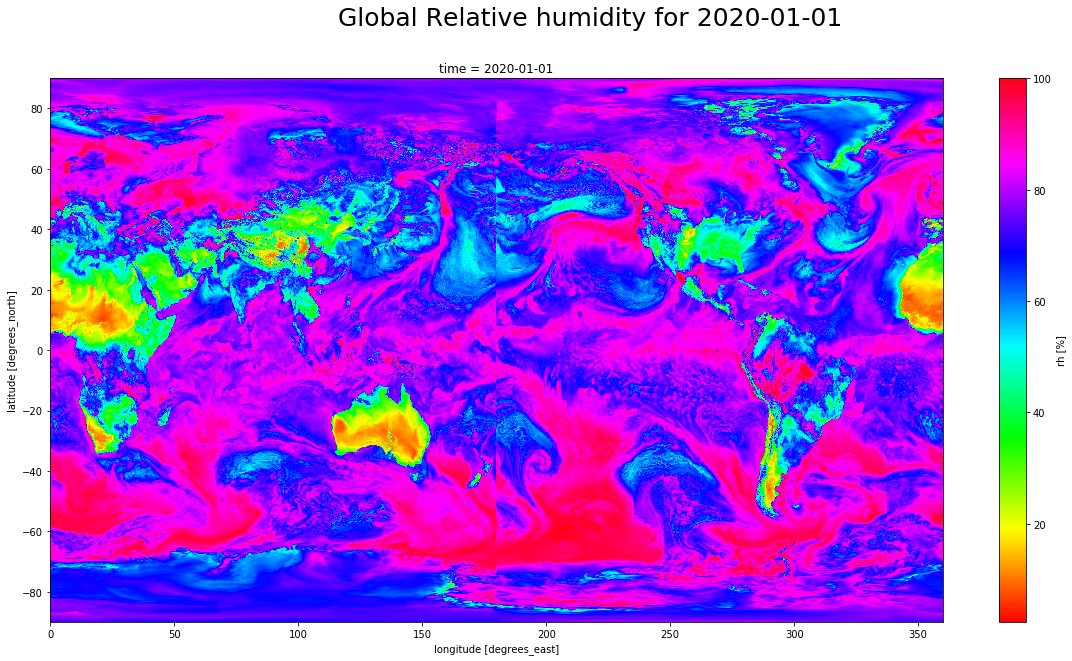

In [18]:
plt.figure(figsize = (20,10)).suptitle('Global Relative humidity for 2020-01-01', fontsize=25)
proc.rh[0].plot(cmap='hsv')

*Notice the discontinuity in the middle*<br>
It is arising because of recording the data at local noon. Shifting the frame:

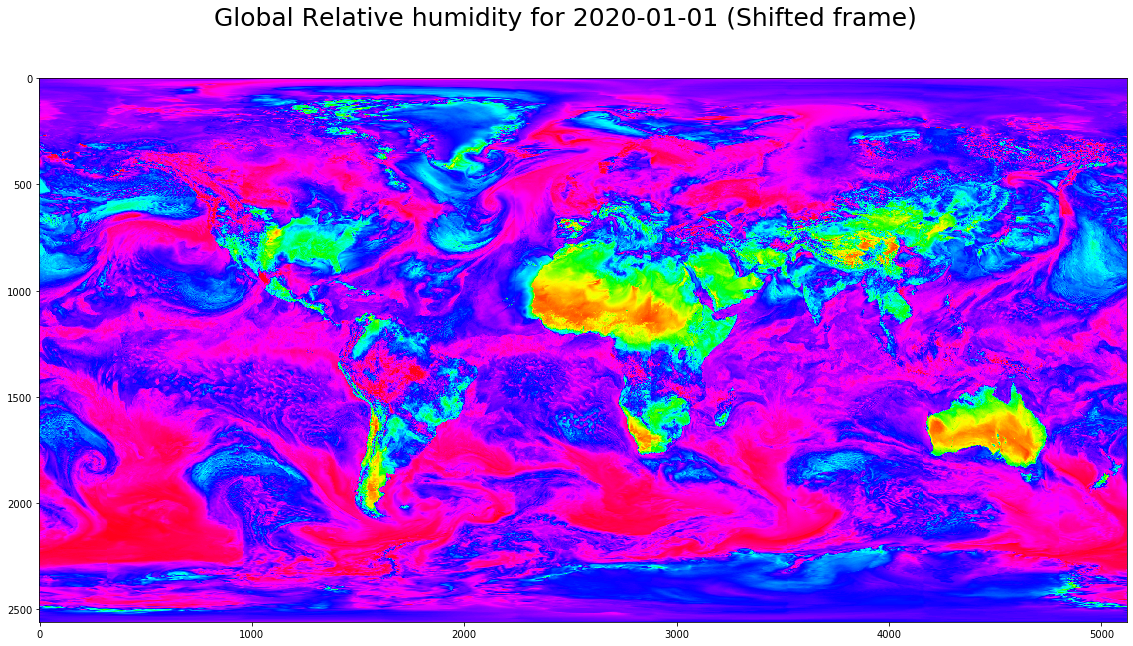

In [19]:
plt.figure(figsize = (20,10)).suptitle('Global Relative humidity for 2020-01-01 (Shifted frame)', fontsize=25)
plt.imshow(np.concatenate((proc.rh[0].values[:,2560:], proc.rh[0].values[:,:2560]), axis=1), cmap='hsv')

Checking for NaN values.<br>
Numpy array for the `xarray` dataarray can be accessed by `values` attribute. `numpy` provides `isnan` function which returns a boolean mask. `any` method on numpy array can be used to check for atleast one instance of NaN value.

In [42]:
for i in proc.data_vars:
    print(np.isnan(proc[i][0].values).any())

False
False
False
False


Printing general stats.

In [20]:
def stats(x):
    tmp = x.mean().values
    print('mean', tmp)
    print('mad', abs(x-tmp).mean().values)
    print('var', x.var().values)
    print('min', x.min().values)
    print('max', x.max().values)

In [21]:
stats(proc.rh)

mean 72.47605
mad 13.0844555
var 314.80286
min 0.0013500393
max 100.064285


In [22]:
stats(proc.t2)

mean 279.96622
mad 16.938044
var 452.84903
min 193.66562
max 324.16202


In [23]:
stats(proc.tp)

mean 2.4548044
mad 3.0407052
var 40.771793
min 0.0
max 1097.1971


In [24]:
stats(proc.wspeed)

mean 6.4765906
mad 2.936887
var 13.666987
min 5.722046e-05
max 47.25583
